# Conditional Neural Process (CNP)

```{figure} ../images/computational_graph_CNPs.svg
---
width: 300em
name: computational_graph_CNPs
alt: Computational graph CNP
---
Computational graph for Conditional Neural Processes.
```

In this notebook we will show how to train a CNP on samples from GPs and images using our framework, as well as how to make nice visualizations. 
CNPs are CNPFs that use a mean aggregation (computational graph in {numref}`computational_graph_CNPs`).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import matplotlib.pyplot as plt
import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## Initialization

Let's load all the data. For more details about the data and some samples, see the {doc}`data <Datasets>` notebook.

In [2]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

# DATASETS
# merges : get_datasets_single_gp, get_datasets_varying_hyp_gp, get_datasets_varying_kernel_gp
gp_datasets, gp_test_datasets, gp_valid_datasets = get_all_gp_datasets()
# image datasets
img_datasets, img_test_datasets = get_img_datasets(["celeba32", "mnist", "zsmms"])

Now let's define the context target splitters using `CntxtTrgtGetter`, which given a data point will return the context set and target set by selecting randomly selecting some points and preprocessing them so that the features are in $[-1,1]$.
To make it compatible with the collate function (a function that "batchifies" the samples) of Pytorch dataloaders, we wrap it by `cntxt_trgt_collate`.

For the 1d case  :
- target set : entire sample (`get_all_indcs`).
- context set : uniformly select between 0 and 50 points (`GetRandomIndcs(a=0.0, b=50)`).

For the 2d case we use `GridCntxtTrgtGetter,RandomMasker,no_masker` which are wrappers around `CntxtTrgtGetter,GetRandomIndcs,get_all_indcs`  :
- target set : entire sample.
- context set : uniformly select between 0 and $30\%$ of the pixels.

In the case of `zsmms`, which test on a different canvas size (extrapolation) than during training, we will define a special context target splitter which preprocesses the features to the correct extrapolation range $[- \frac{56}{32}, \frac{56}{32}]$ instead of the usual $[- 1, 1]$.

```{admonition} tip
There are many more ways of splitting context and target functions in `npf.utils.datasplit`.
```

In [3]:
from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs,
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
# 1d
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.0, b=50), targets_getter=get_all_indcs,
    )
)

# same as in 1D but with masks (2d) rather than indices
get_cntxt_trgt_2d = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0.0, b=0.3), target_masker=no_masker,
    )
)

# for ZSMMS you need the pixels to not be in [-1,1] but [-1.75,1.75] (i.e 56 / 32) because you are extrapolating
get_cntxt_trgt_2d_extrap = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0, b=0.3),
        target_masker=no_masker,
        upscale_factor=get_test_upscale_factor("zsmms"),
    )
)

Let's now define the models. For both the 1D and 2D case we will be using the following:
* **Encoder** $\mathrm{e}_{\boldsymbol{\theta}}$ : a 1-hidden layer MLP that encodes the features $\{x^{(i)}\} \mapsto \{x_{transformed}^{(i)}\}$ (`XEncoder`), followed by a 2 hidden layer MLP that encodes each feature-value pair $\{x_{transformed}^{(i)}, y^{(i)}\} \mapsto \{R^{(i)}\}$ (`XYEncoder`).
* **Aggregator** $\mathrm{Agg}$: mean operator.
* **Decoder** $\mathrm{d}_{\boldsymbol{\theta}}$: a 4 hidden layer MLP that predicts the distribution of the target value given the global representation and target context $\{R, x^{(t)}\} \mapsto \{\mu^{(t)}, \sigma^{2(t)}\}$.

All hidden representations will be of `R_DIM=128` dimensions besides the encoder which has width $128*2$ for the 1D case and $128*3$ for the 2D case (to have similar number of parameters than other NPFs). Note that in the implementation the only differences between images and samples form GPs is `x_dim=2`.


In [4]:
from functools import partial

from npf import CNP
from npf.architectures import MLP, merge_flat_input
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    XEncoder=partial(MLP, n_hidden_layers=1, hidden_size=R_DIM),
    Decoder=merge_flat_input(  # MLP takes single input but we give x and R so merge them
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), is_sum_merge=True,
    ),
    r_dim=R_DIM,
)

# 1D case
model_1d = partial(
    CNP,
    x_dim=1,
    y_dim=1,
    XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM * 2), is_sum_merge=True,
    ),
    **KWARGS,
)

# image (2D) case
model_2d = partial(
    CNP,
    x_dim=2,
    XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM * 3), is_sum_merge=True,
    ),
    **KWARGS,
)  # don't add y_dim yet because depends on data (colored or gray scale)

# Param count
n_params_1d = count_parameters(model_1d())
n_params_2d = count_parameters(model_2d(y_dim=3))
print(f"Number Parameters (1D): {n_params_1d:,d}")
print(f"Number Parameters (2D): {n_params_2d:,d}")

Number Parameters (1D): 252,098
Number Parameters (2D): 367,750


For all the CNPFs, we tried to keep the number of parameters comparable.

For more details about all the possible parameters, refer to the docstrings of `CNP` and the base class `NeuralProcessFamily`.

In [5]:
# CNP Docstring
print(CNP.__doc__)


    Conditional Neural Process from [1].

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    XYEncoder : nn.Module, optional
        Encoder module which maps {x_transf_i, y_i} -> {r_i}. It should be constructable
        via `XYEncoder(x_transf_dim, y_dim, n_out)`. If you have an encoder that maps
        [x;y] -> r you can convert it via `merge_flat_input(Encoder)`. `None` uses
        MLP. In the computational model this corresponds to `h` (with XEncoder). 
        Example:
            - `merge_flat_input(MLP, is_sum_merge=False)` : learn representation
            with MLP. `merge_flat_input` concatenates (or sums) X and Y inputs.
            - `merge_flat_input(SelfAttention, is_sum_merge=True)` : self attention mechanisms as 
            [4]. For more parameters (attention type, number of layers ...) refer to its docstrings.
            - `discard_ith_arg(MLP, 0)` if want the encoding to only depend o

In [6]:
# NeuralProcessFamily Docstring
from npf import NeuralProcessFamily

print(NeuralProcessFamily.__doc__)


    Base class for members of the neural process family.

    Notes
    -----
    - when writing size of vectors something like `size=[batch_size,*n_cntxt,y_dim]` means that the
    first dimension is the batch, the last is the target values and everything in the middle are context 
    points. We use `*n_cntxt` as it can  be a single flattened dimension or many (for example on the grid).

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    encoded_path : {"latent", "both", "deterministic"}
        Which path(s) to use:
        - `"deterministic"` no latents : the decoder gets a deterministic representation s input.
        - `"latent"` uses latent : the decoder gets a sample latent representation as input.
        - `"both"` concatenates both the deterministic and sampled latents as input to the decoder.

    r_dim : int, optional
        Dimension of representations.

    x_transf_dim : int, optional
     

### Training

The main function for training is `train_models` which trains a dictionary of models on a dictionary of datasets and returns all the trained models.
See its docstring for possible parameters.

In [7]:
# train_models Docstring
from utils.train import train_models

print(train_models.__doc__)


    Train or loads the models.

    Parameters
    ----------
    datasets : dict
        The datasets on which to train the models. 

    models : dict
        The models to train (initialized or not). Each model will be trained on
        all datasets. If the initialzed models are passed, it will continue
        training from there.  Can also give a dictionary of dictionaries, if the
        models to train depend on the dataset.

    criterion : nn.Module
        The uninitialized criterion (loss).

    test_datasets : dict, optional
        The test datasets. If given, the corresponding models will be evaluated
        on those, the log likelihood for each datapoint will be saved in the
        in the checkpoint directory as `eval.csv`.

    valid_datasets : dict, optional
        The validation datasets. 

    chckpnt_dirname : str, optional
        Directory where checkpoints will be saved. The best (if validation or train_split given)
        or last model will be saved.

    

Computational Notes :
- The following will either train all the models (`is_retrain=True`) or load the pretrained models (`is_retrain=False`)
- it will use a (single) GPU if available
- decrease the batch size if you don't have enough memory
- 30 epochs should give you descent results for the GP datasets (instead of 100)

In [8]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=CNPFLoss,  # Standard loss for conditional NPFs
    chckpnt_dirname="results/pretrained/",
    device=None,  # use GPU if available
    batch_size=32,
    lr=1e-3,
    decay_lr=10,  # decrease learning rate by 10 during training
    seed=123,
)


# 1D
trainers_1d = train_models(
    gp_datasets,
    {"CNP": model_1d},
    test_datasets=gp_test_datasets,
    train_split=None,  # No need for validation as the training data is generated on the fly
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)


# 2D
trainers_2d = train_models(
    img_datasets,
    add_y_dim({"CNP": model_2d}, img_datasets),  # y_dim (channels) depend on data
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    datasets_kwargs=dict(
        zsmms=dict(iterator_valid__collate_fn=get_cntxt_trgt_2d_extrap,)
    ),  # for zsmm use extrapolation
    max_epochs=50,
    **KWARGS
)


--- Loading RBF_Kernel/CNP/run_0 ---

RBF_Kernel/CNP/run_0 | best epoch: None | train loss: 8.4633 | valid loss: None | test log likelihood: -16.1129

--- Loading Periodic_Kernel/CNP/run_0 ---

Periodic_Kernel/CNP/run_0 | best epoch: None | train loss: 129.0426 | valid loss: None | test log likelihood: -126.4177

--- Loading Noisy_Matern_Kernel/CNP/run_0 ---

Noisy_Matern_Kernel/CNP/run_0 | best epoch: None | train loss: 111.3382 | valid loss: None | test log likelihood: -115.7692

--- Loading Variable_Matern_Kernel/CNP/run_0 ---

Variable_Matern_Kernel/CNP/run_0 | best epoch: None | train loss: -91.6702 | valid loss: None | test log likelihood: -1076.2766

--- Loading All_Kernels/CNP/run_0 ---

All_Kernels/CNP/run_0 | best epoch: None | train loss: 79.7617 | valid loss: None | test log likelihood: -80.6751

--- Loading celeba32/CNP/run_0 ---

celeba32/CNP/run_0 | best epoch: 49 | train loss: -2554.1602 | valid loss: -2621.283 | test log likelihood: 2559.7317

--- Loading mnist/CNP/ru

### Plots

Let's visualize how well the model performs in different settings.

#### GPs Dataset

Let's define a plotting function that we will use in this section. 
For each dataset-model pair it plots the posterior distribution for various context sets (aggregated in a gif). 

The main functions we are using are:
1. `giffify` : call multiple times a function with different parameters and make a gif with the outputs.
2. `plot_multi_posterior_samples_1d` : sample some context and target set for each dataset, call `plot_posterior_samples_1d`, and aggregate the plots row wise.
3. `plot_posterior_samples_1d` : core underlying plotting function.

Some important parameters are shown below, for more information refer to the docstrings of these functions .

In [9]:
from utils.ntbks_helpers import PRETTY_RENAMER, plot_multi_posterior_samples_1d
from utils.visualize import giffify


def multi_posterior_gp_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_1d,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[1, 2, 5, 7, 10, 15, 20, 30, 50, 100],
        fps=1.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        is_plot_generator=True,  # plot underlying GP
        is_plot_real=False,  # don't plot sampled / underlying function
        is_plot_std=True,  # plot the predictive std
        is_fill_generator_std=False,  # do not fill predictive of GP
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        # Fix formatting for coherent GIF
        plot_config_kwargs=dict(
            set_kwargs=dict(ylim=[-3, 3]), rc={"legend.loc": "upper right"}
        ),
        seed=seed,
        **kwargs,
    )

Let us visualize the CNP when it is trained on samples from a single GP.

In [10]:
def filter_single_gp(d):
    """Select only data form single GP."""
    return {k: v for k, v in d.items() if ("All" not in k) and ("Variable" not in k)}


multi_posterior_gp_gif(
    "CNP_single_gp",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
)

```{figure} ../gifs/CNP_single_gp.gif
---
width: 40em
name: CNP_single_gp
alt: CNP on single GPs
---

Posterior predictive of CNPs (Blue line with shaded area for $\mu \pm \sigma$) and the oracle GP (Green line with dashes for $\mu \pm \sigma$) when conditioned on contexts points (Black) from an underlying function sampled from a GP. Each row corresponds to a different kernel and CNP trained on samples for the corresponding GP. 
```

From {numref}`CNP_single_gp` we see that CNP captures some information from the underlying GP, but (i) it suffers from underfitting in the case of RBF and Matern kernel; (ii) it is not able to model the periodic kernel.

In [11]:
###### ADDITIONAL 1D PLOTS ######

### RBF ###
def filter_rbf(d):
    """Select only data form RBF."""
    return {k: v for k, v in d.items() if ("RBF" in k)}


multi_posterior_gp_gif(
    "CNP_rbf",
    trainers=filter_rbf(trainers_1d),
    datasets=filter_rbf(gp_test_datasets),
)

### Periodic ###
def filter_periodic(d):
    """Select only data from periodic."""
    return {k: v for k, v in d.items() if ("Periodic" in k)}


multi_posterior_gp_gif(
    "CNP_periodic",
    trainers=filter_periodic(trainers_1d),
    datasets=filter_periodic(gp_test_datasets),
)

### Extrap ###
multi_posterior_gp_gif(
    "CNP_single_gp_extrap",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
)

### Varying hyperparam ###
def filter_hyp_gp(d):
    return {k: v for k, v in d.items() if ("Variable" in k)}


multi_posterior_gp_gif(
    "CNP_vary_gp",
    trainers=filter_hyp_gp(trainers_1d),
    datasets=filter_hyp_gp(gp_test_datasets),
    model_labels=dict(main="Model", generator="Fitted GP"),
)

### All kernels ###
# data with varying kernels simply merged single kernels
single_gp_datasets = filter_single_gp(gp_test_datasets)

# use same trainer for all, but have to change their name to be the same as datasets
base_trainer_name = "All_Kernels/CNP/run_0"
trainer = trainers_1d[base_trainer_name]
replicated_trainers = {}
for name in single_gp_datasets.keys():
    replicated_trainers[base_trainer_name.replace("All_Kernels", name)] = trainer

multi_posterior_gp_gif(
    "CNP_kernel_gp",
    trainers=replicated_trainers,
    datasets=single_gp_datasets,
)

#### Image Dataset


Let us now look at the case of more realistic datasets, when we do not have access to the underlying data generating process : images.

For plotting, we will again use `giffify` to make a gif for different context sets. The code is very similar but we have to replace `plot_multi_posterior_samples_1d`, `plot_posterior_samples_1d` by `plot_multi_posterior_samples_imgs`, `plot_posterior_samples`

In [12]:
from utils.ntbks_helpers import plot_multi_posterior_samples_imgs


def multi_posterior_imgs_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[
            0,  
            0.005,
            0.01,
            0.02,
            0.05,
            0.1,
            0.15,
            0.2,
            0.3,
            0.5,
            "hhalf",  # horizontal half of the image
            "vhalf",  # vertival half of the image
        ],
        fps=1.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        n_plots=3,  # images per datasets
        is_plot_std=True,  # plot the predictive std
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        plot_config_kwargs={"font_scale":0.7},
        # Fix formatting for coherent GIF
        seed=seed,
        **kwargs,
    )

Let us visualize the CNP when it is trained on samples from different image datasets that do not involve extrapolation.

In [13]:
def filter_interpolation(d):
    """Filter out zsmms which requires extrapolation."""
    return {k: v for k, v in d.items() if "zsmms" not in k}


multi_posterior_imgs_gif(
    "CNP_img_interp",
    trainers=filter_interpolation(trainers_2d),
    datasets=filter_interpolation(img_test_datasets),
)

```{figure} ../gifs/CNP_img_interp.gif
---
width: 40em
name: CNP_img_interp
alt: CNP on CelebA and MNIST
---

Mean and std of the posterior predictive of a CNP for CelebA $32\times32$ and MNIST for different context sets.
```

From {numref}`CNP_img_interp` we see that the CNPs again underfit, to the point where it cannot even predict well when conditioned on the entire image (see MNIST).

To make sure that the samples are representative / not cherry picked, we can explicitly sample images and context sets that reached a given percentile of the test log likelihood.
This is done using `plot_qualitative_with_kde`.


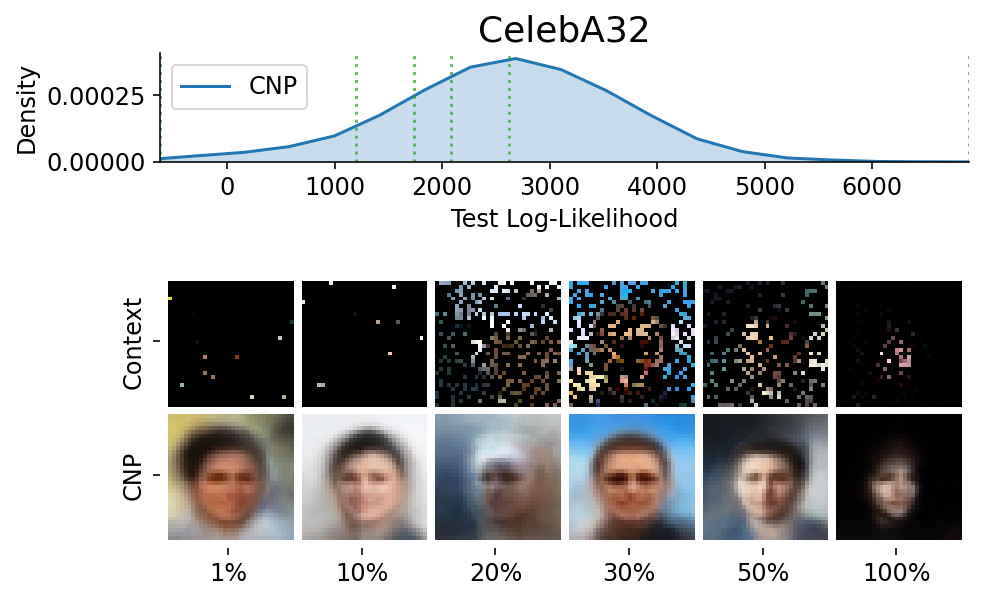

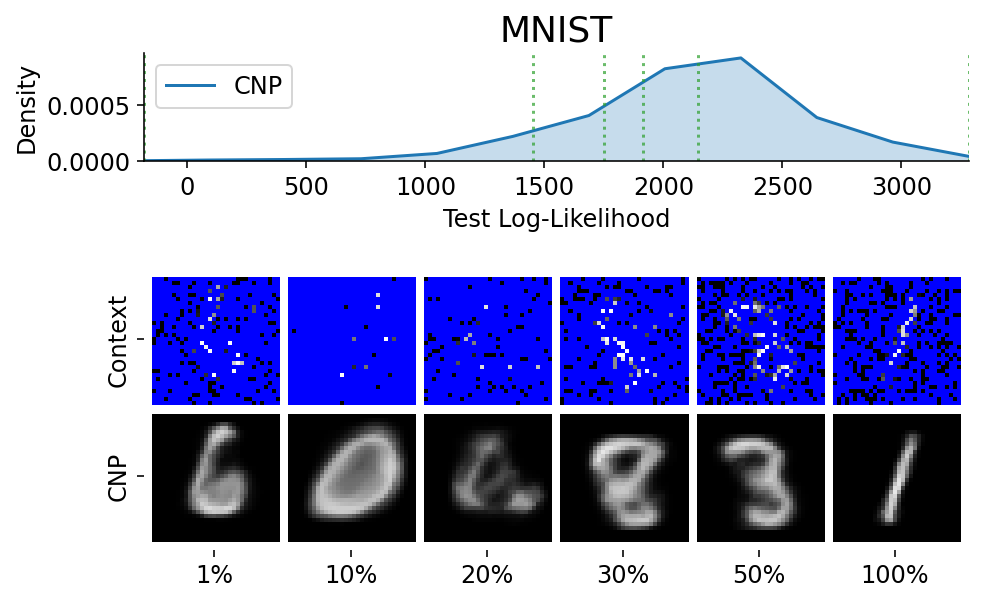

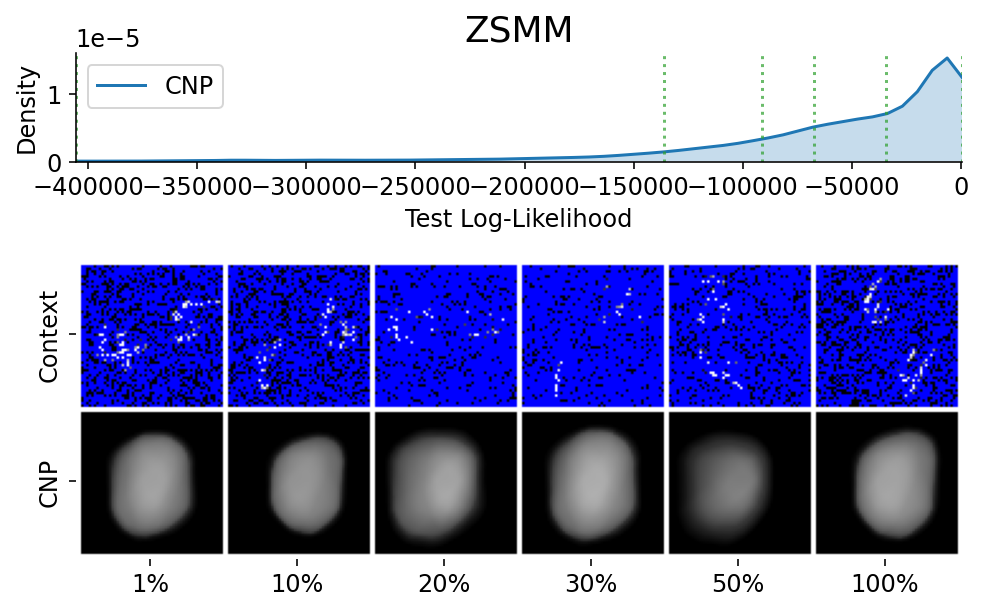

In [14]:
from utils.visualize import plot_qualitative_with_kde

n_trainers = len(trainers_2d)
for i, (k, trainer) in enumerate(trainers_2d.items()):
    data_name = k.split("/")[0]
    model_name = k.split("/")[1]
    dataset = img_test_datasets[data_name]

    plot_qualitative_with_kde(
        [PRETTY_RENAMER[model_name], trainer],
        dataset,
        figsize=(7, 5),
        percentiles=[1, 10, 20, 30, 50, 100],  # desired test percentile
        height_ratios=[1, 5],  # kde / image ratio
        is_smallest_xrange=True,  # rescale X axis based on percentile
        h_pad=-1,  # padding
        title=PRETTY_RENAMER[data_name],
        upscale_factor=get_test_upscale_factor(data_name),
    )

In [15]:
###### ADDITIONAL 2D PLOTS ######

### Gif all images ###
multi_posterior_imgs_gif("CNP_img", trainers=trainers_2d, datasets=img_test_datasets)